In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    f = f[0]
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
class ImageTuple(fastuple):
    @classmethod
    def create(cls, fns): 
        return cls(tuple(PILImage.create(f) for f in fns))
    
    def show(self, ctx=None, **kwargs): 
        t1,t2 = self
        if not isinstance(t1, Tensor) or not isinstance(t2, Tensor) or t1.shape != t2.shape: return ctx
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), ctx=ctx, **kwargs)

In [13]:
def ImageTupleBlock(): return TransformBlock(type_tfms=ImageTuple.create, batch_tfms=IntToFloatTensor)

In [14]:
def get_tuples(files):
    return [[f, Path(str(f).replace('datasetClean','datasetAltura2'))] for f in get_image_files(files)]

In [15]:
class MyTransform(Transform):
    def __init__(self): self.aug = aug_transforms(size=224,flip_vert=True,max_zoom=1.0)
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [16]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = [Resize(presize)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [17]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [18]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=64)

In [19]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50Masav2HeightOrtofotov2')
]

In [20]:
from fastai.metrics import mae,rmse,mse

In [21]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x):
        x1,x2=x
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [22]:
model = timm.create_model('resnetrs50',num_classes=1,pretrained=True)

In [23]:
encoder = nn.Sequential(*list(model.children())[:-2])

In [24]:
head = create_head(4096, 1, ps=0.5)
model = SiameseModel(encoder, head)

In [25]:
def siamese_splitter(model):
    return [params(model.encoder), params(model.head)]

In [26]:
learn = Learner(dls, model,splitter=siamese_splitter,
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [27]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,112722.742188,126379.234375,285.413879,355.498566,126379.234375,00:05


Better model found at epoch 0 with valid_loss value: 126379.234375.


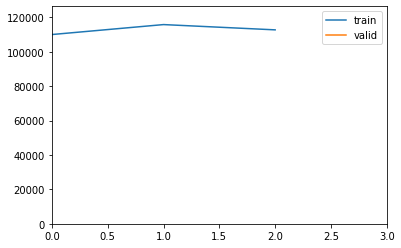

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,112783.851562,126350.726562,285.356140,355.458496,126350.726562,00:04
1,111565.914062,126312.445312,285.281982,355.404602,126312.445312,00:04
2,109999.773438,126312.210938,285.268188,355.404297,126312.210938,00:04
3,107595.679688,126311.562500,285.261047,355.403381,126311.562500,00:04
4,107549.421875,123647.695312,284.495697,351.635712,123647.695312,00:04
5,107171.570312,122433.414062,284.175232,349.904877,122433.414062,00:04
6,106505.210938,121695.585938,283.323364,348.848907,121695.585938,00:04
7,105863.867188,120681.585938,282.820190,347.392578,120681.585938,00:04
8,105859.843750,119803.101562,282.666260,346.125854,119803.101562,00:04
9,104211.843750,118721.078125,282.050476,344.559235,118721.078125,00:04


Better model found at epoch 0 with valid_loss value: 126350.7265625.


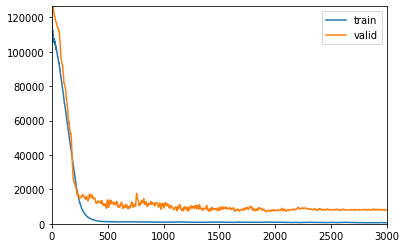

Better model found at epoch 1 with valid_loss value: 126312.4453125.
Better model found at epoch 2 with valid_loss value: 126312.2109375.
Better model found at epoch 3 with valid_loss value: 126311.5625.
Better model found at epoch 4 with valid_loss value: 123647.6953125.
Better model found at epoch 5 with valid_loss value: 122433.4140625.
Better model found at epoch 6 with valid_loss value: 121695.5859375.
Better model found at epoch 7 with valid_loss value: 120681.5859375.
Better model found at epoch 8 with valid_loss value: 119803.1015625.
Better model found at epoch 9 with valid_loss value: 118721.078125.
Better model found at epoch 10 with valid_loss value: 118056.7109375.
Better model found at epoch 11 with valid_loss value: 117396.2734375.
Better model found at epoch 12 with valid_loss value: 116597.1484375.
Better model found at epoch 13 with valid_loss value: 116361.7734375.
Better model found at epoch 14 with valid_loss value: 115564.6640625.
Better model found at epoch 15 wi

In [28]:
learn.fine_tune(1000,base_lr=3e-2)

In [29]:
# learn.load('resnetrs50Masav2HeightOrtofotov2')

In [30]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [31]:
def is_test(f):
    f = f[0]
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [32]:
dbtest = DataBlock(blocks = (ImageTupleBlock, RegressionBlock()),
                 get_items=get_tuples, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = [Resize(224)],
                 batch_tfms=[MyTransform(),Normalize.from_stats(*imagenet_stats)])

In [33]:
dlstest = dbtest.dataloaders(path,bs=16)

In [34]:
learn.dls=dlstest

In [35]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 68.97974395751953.


(#4) [7701.462890625,68.97974395751953,87.75798797607422,7701.462890625]

In [36]:
from sklearn.metrics import mean_absolute_error

In [37]:
preds,gt = learn.tta()

In [38]:
mean_absolute_error(gt,preds)

71.866455